In [4]:
import tvm
from tvm import relay
from tvm.contrib import graph_executor
import onnx
import numpy as np
import matplotlib.pyplot as pl

In [3]:
pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.1/166.1 kB 1.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 21.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 24.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 29.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 7.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
onnx_model_path = "resnet_model.onnx"  
onnx_model = onnx.load(onnx_model_path)

In [10]:
target = "llvm"  
input_name = "input" 
input_shape = (1, 32, 32, 3) 

In [11]:
shape_dict = {input_name: input_shape}
mod, params = relay.frontend.from_onnx(onnx_model, shape_dict)


In [51]:
with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(mod, target=target, params=params)


In [13]:
ctx = tvm.cpu()     
module = graph_executor.GraphModule(lib["default"](ctx))

In [37]:
import os

output_directory = "./optimized_model"  # Directory to save the compiled files
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

In [38]:
model_lib_path = f"{output_directory}/model.so"  # Path for the shared library
graph_json_path = f"{output_directory}/graph.json"  # Path for the model graph
params_path = f"{output_directory}/params.bin"  # Path for the model parameters

In [39]:
lib.export_library(model_lib_path)

In [40]:
with open(graph_json_path, "w") as f:
    f.write(lib.get_graph_json())  
with open(params_path, "wb") as f:
    f.write(relay.save_param_dict(params))

In [41]:
graph_json = lib.get_graph_json()  # Get the optimized graph as JSON


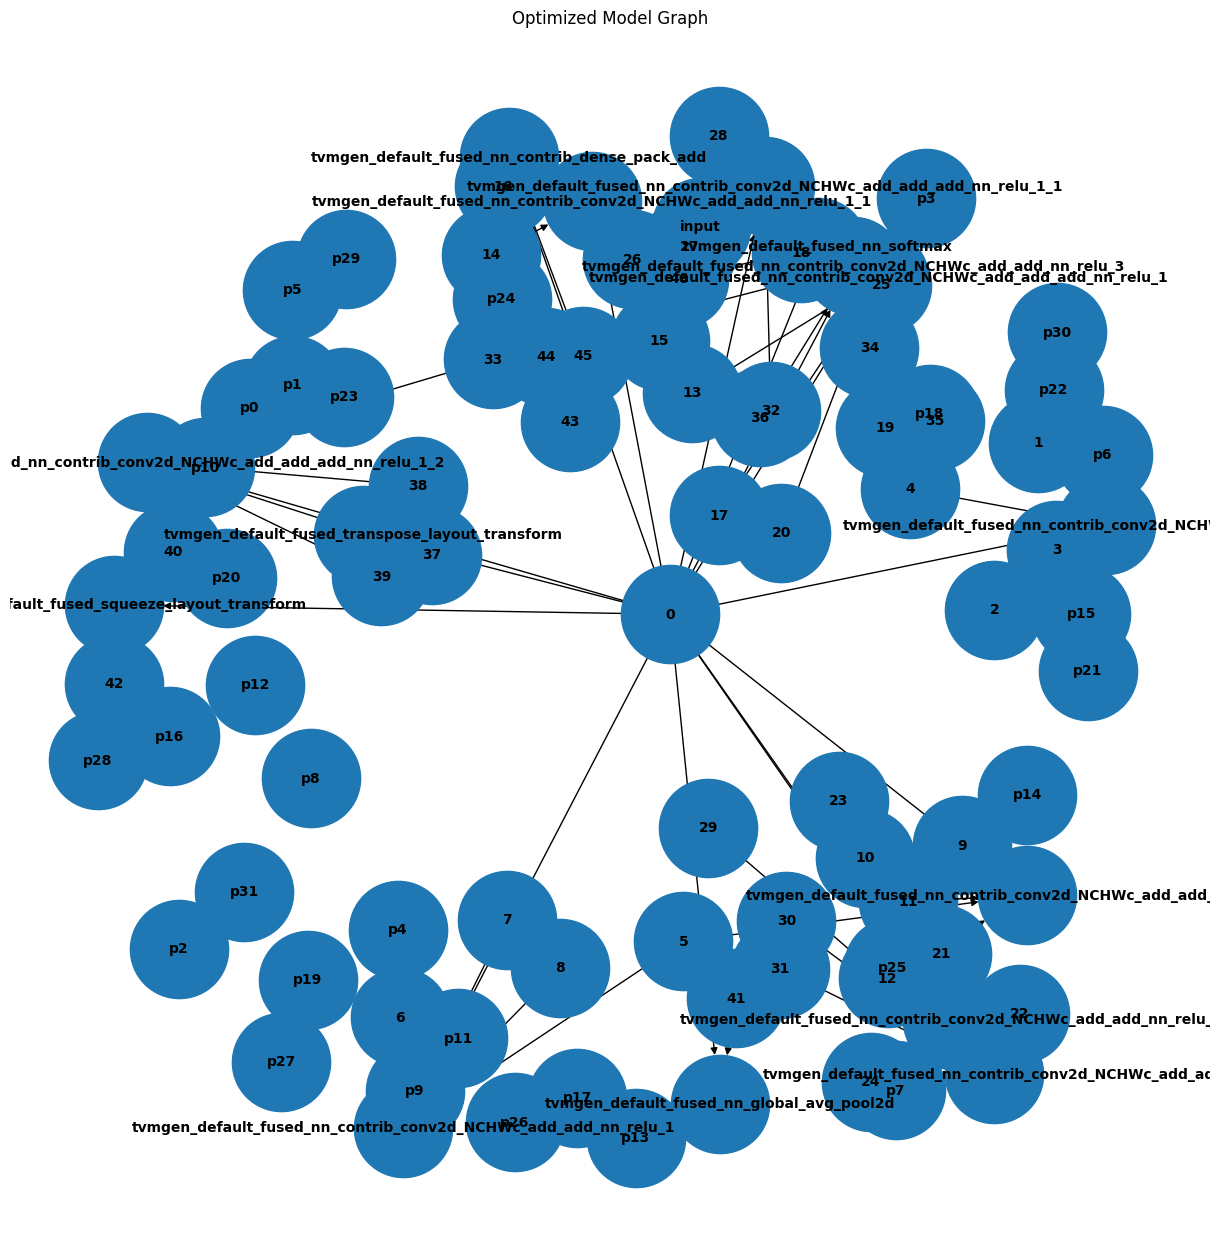

In [ ]:
import json
import networkx as nx
import matplotlib.pyplot as plt


graph_dict = json.loads(graph_json)  


G = nx.DiGraph()


for node in graph_dict["nodes"]:
    node_name = node["name"]  
    G.add_node(node_name) 
    
    
    for edge in node.get("inputs", []):
       
        if isinstance(edge, list):
            for sub_edge in edge:
                G.add_edge(sub_edge, node_name)  
        else:
            G.add_edge(edge, node_name)  

h
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15, iterations=20)  
nx.draw(G, pos, with_labels=True, node_size=5000, font_size=10, font_weight='bold')
plt.title("Optimized Model Graph")
plt.show()
